<a href="https://colab.research.google.com/github/aguilarafa2010/DL_CIFAR10/blob/main/Deep_Learning_(a).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout
from keras import regularizers
import keras

import matplotlib.pyplot as plt
import matplotlib.style as sty

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

import os
import random as rn
import tensorflow as tf
import seaborn as sns

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [ ]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
# define cnn model
def define_model(img_size=32):
	batch_size=128
	weight_decay=1e-4
	model = Sequential()
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='he_uniform', padding='same', input_shape=(img_size, img_size, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
 
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(BatchNormalization())
	model.add(Dropout(0.3))

	model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(BatchNormalization())
	model.add(Dropout(0.4))

	model.add(Flatten())
	model.add(Dense(4096, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
	#opt = SGD(lr=0.001, momentum=0.3)
	#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
#Configurações Arbritarias escolhidas para treinamento
batch_size = 128
num_classes = 10
epochs = 100

In [ ]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
print(trainX.shape)
print(testX.shape)
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# define model
model = define_model()

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
# Treinamento: exemplo onde usamos EarlyStopping 
es  = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
results = model.fit(trainX, trainY, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks = [es],
          validation_split=0.2)

Epoch 1/100
313/313 [==============================] - 6s 21ms/step - loss: 2.8571 - accuracy: 0.2852 - val_loss: 1.9619 - val_accuracy: 0.3624
Epoch 2/100
313/313 [==============================] - 6s 21ms/step - loss: 2.8325 - accuracy: 0.2894 - val_loss: 1.9484 - val_accuracy: 0.3684
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 2.7896 - accuracy: 0.2968 - val_loss: 1.9491 - val_accuracy: 0.3685
Epoch 00003: early stopping


In [ ]:
#Realiza avaliação final da rede 
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 1.9431880712509155
Test accuracy: 0.44429999589920044


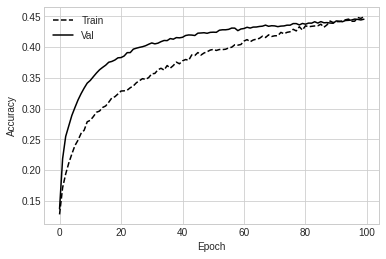

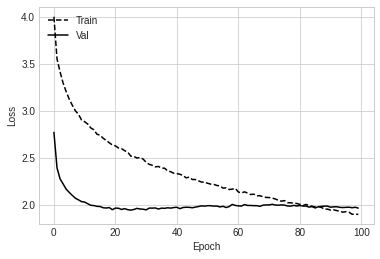

In [ ]:
# Plota o grafico do histórico de evolução da taxa de acertos da rede
sty.use('seaborn-whitegrid')
plt.plot(results.history['accuracy'],'k--')
plt.plot(results.history['val_accuracy'],'k')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


# Plota o grafico do histórico de evolução da taxa de perda da rede 
plt.plot(results.history['loss'],'k--')
plt.plot(results.history['val_loss'],'k')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
y_predict = np.argmax(model.predict(testX), axis=-1)

In [ ]:
cm = confusion_matrix(np.argmax(testY,axis=1),y_predict)

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']

In [ ]:
#Função para realizar e plotar a matrix de confusão 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  
  print(cm)
  
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
   
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[492  22   7   5  47   1 187  17 196  26]
 [ 18 527   0   0  21   0 228  10  92 104]
 [ 66  13  59  12 313  21 437  46  26   7]
 [  9   9   6  56 121  47 685  35  14  18]
 [ 22   3   2   2 466   6 438  39  17   5]
 [  5   5   7  43 183 188 446  92  23   8]
 [  2   2   0   0  41   0 950   1   2   2]
 [ 11   5   4   8 140  18 272 497  12  33]
 [ 35  40   0   1  22   0 148  10 727  17]
 [ 19 111   0   0  14   1 228  30 116 481]]


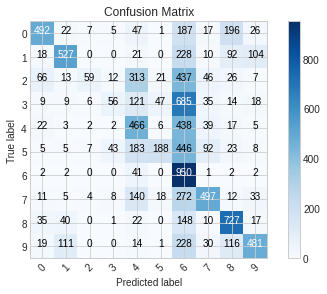

In [ ]:
plot_confusion_matrix(cm,cm_plot_labels,title ='Confusion Matrix')